MÓDULO 1 - Previsão de Aptidão Viral a Nível Molecular

1.1. Configuração de Packages e Bibliotecas

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import random
import matplotlib.dates as mdates

from Bio import SeqIO
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# Configuração visual
%matplotlib inline
sns.set_theme(style="whitegrid")



1.2. Tratamento de Dados

In [168]:
# Sequências
fasta_file = "influenzaA_HA_H1N1_human_2017.fasta"
sequences = list(SeqIO.parse(fasta_file, "fasta"))

df_sequences = pd.DataFrame([
    {"sequence_id": seq.id, "sequence": str(seq.seq), "length": len(seq.seq)}
    for seq in sequences
])

# Epidemiologia (FluNet)
df_metadata = pd.read_excel("metadados.xlsx")
df_metadata['ISO_SDATE'] = pd.to_datetime(df_metadata['ISO_SDATE']).dt.tz_localize(None)

print(f"Total de sequências: {len(df_sequences)}")
print(f"Total de registos epidemiológicos: {len(df_epi)}")


Total de sequências: 383
Total de registos epidemiológicos: 26


In [169]:
df_sequences.head()


,sequence_id,sequence,length
0,AWH65845.1,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566
1,AWH65844.1,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566
2,ANE37269.1,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566
3,ANA11367.1,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566
4,ANA11356.1,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,566


In [170]:
df_metadata.head()

,WHO region,ITZ,COUNTRY/AREA/TERRITORY,COUNTRY_CODE,ORIGIN_SOURCE,ISO_YEAR,ISO_WEEK,ISO_SDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,...,AH5,ANOTSUBTYPED,INF_A,BVIC,BYAM,BNOTDETERMINED,INF_B,INF_ALL,INF_NEGATIVE,ILI_ACTIVITY
0,SEAR,Southern Asia,India,IND,NOTDEFINED,2017,40,2017-10-01 23:00:00,488,488,...,NaN,NaN,85,NaN,NaN,NaN,NaN,85,403.0,5
1,SEAR,Southern Asia,India,IND,NOTDEFINED,2017,41,2017-10-08 23:00:00,382,382,...,NaN,NaN,53,NaN,NaN,NaN,NaN,53,NaN,5
2,SEAR,Southern Asia,India,IND,NOTDEFINED,2017,42,2017-10-15 23:00:00,272,272,...,NaN,NaN,43,NaN,NaN,2.0,2.0,45,229.0,5
3,SEAR,Southern Asia,India,IND,NOTDEFINED,2017,43,2017-10-22 23:00:00,378,378,...,NaN,NaN,24,NaN,NaN,NaN,NaN,24,360.0,3
4,SEAR,Southern Asia,India,IND,NOTDEFINED,2017,44,2017-10-30 00:00:00,281,281,...,NaN,NaN,21,NaN,NaN,NaN,NaN,21,260.0,3


1.3. Distribuição e Qualidade das Sequências

In [ ]:
valid_amino_acids = re.compile(r'^[ACDEFGHIKLMNPQRSTVWY]+$')
df_sequences = df_sequences[df_sequences["sequence"].str.match(valid_amino_acids)]
df_sequences = df_sequences.drop_duplicates(subset="sequence")
df_sequences = df_sequences[df_sequences["length"] >= 300]

null_counts = df_metadata.isnull().sum()

threshold = 0.5 * len(df_metadata)
cols_to_drop = null_counts[null_counts > threshold].index

df_epi = df_metadata.drop(columns=cols_to_drop)
df_epi = df_epi.dropna(axis=1, how='all')


In [174]:
numeric_cols = df_epi.select_dtypes(include=['int64', 'float64']).columns
df_epi[numeric_cols] = df_epi[numeric_cols].fillna(df_epi[numeric_cols].mean())

categorical_cols = df_epi.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_epi[col] = df_epi[col].fillna(df_epi[col].mode()[0])

print("\nValores nulos após limpeza:")
print(df_epi.isnull().sum())



Valores nulos após limpeza:
WHO region                0
ITZ                       0
COUNTRY/AREA/TERRITORY    0
COUNTRY_CODE              0
ORIGIN_SOURCE             0
ISO_YEAR                  0
ISO_WEEK                  0
ISO_SDATE                 0
SPEC_RECEIVED_NB          0
SPEC_PROCESSED_NB         0
AH1N12009                 0
AH3                       0
INF_A                     0
BYAM                      0
BNOTDETERMINED            0
INF_B                     0
INF_ALL                   0
INF_NEGATIVE              0
ILI_ACTIVITY              0
dtype: int64


In [175]:
print("\nTipos de dados:")
print(df_epi.dtypes)

if 'ISO_SDATE' in df_epi.columns:
    df_epi['ISO_SDATE'] = pd.to_datetime(df_epi['ISO_SDATE'], errors='coerce')

print("\nTipos de dados após conversão:")
print(df_epi.dtypes)


Tipos de dados:
WHO region                        object
ITZ                               object
COUNTRY/AREA/TERRITORY            object
COUNTRY_CODE                      object
ORIGIN_SOURCE                     object
ISO_YEAR                           int64
ISO_WEEK                           int64
ISO_SDATE                 datetime64[ns]
SPEC_RECEIVED_NB                   int64
SPEC_PROCESSED_NB                  int64
AH1N12009                          int64
AH3                              float64
INF_A                              int64
BYAM                             float64
BNOTDETERMINED                   float64
INF_B                            float64
INF_ALL                            int64
INF_NEGATIVE                     float64
ILI_ACTIVITY                       int64
dtype: object

Tipos de dados após conversão:
WHO region                        object
ITZ                               object
COUNTRY/AREA/TERRITORY            object
COUNTRY_CODE                      o

In [182]:
df_epi.to_excel("metadados_limpos.xlsx", index=False)

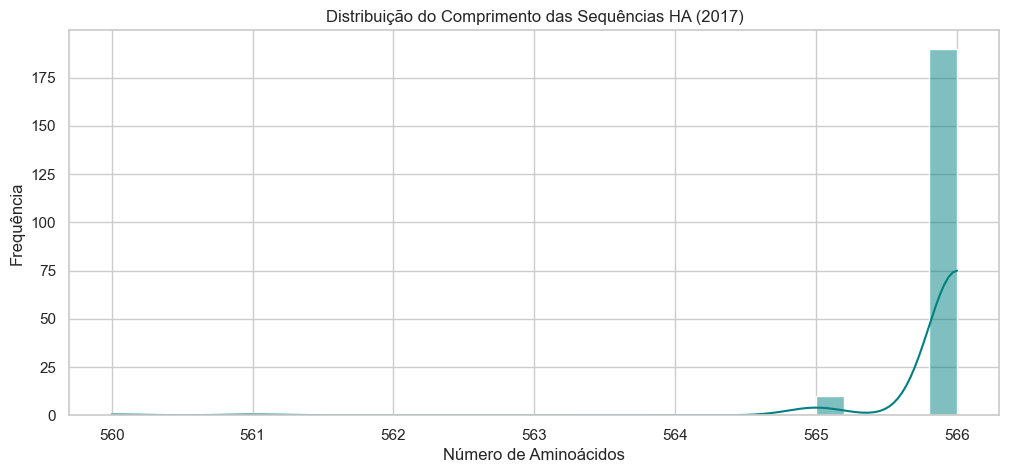

In [140]:
plt.figure(figsize=(12, 5))
sns.histplot(df_sequences['length'], bins=30, kde=True, color='teal')
plt.title("Distribuição do Comprimento das Sequências HA (2017)")
plt.xlabel("Número de Aminoácidos")
plt.ylabel("Frequência")
plt.show()

In [141]:
print("Estatísticas de Comprimento:")
df_sequences['length'].describe()

Estatísticas de Comprimento:


count    202.000000
mean     565.896040
std        0.585126
min      560.000000
25%      566.000000
50%      566.000000
75%      566.000000
max      566.000000
Name: length, dtype: float64

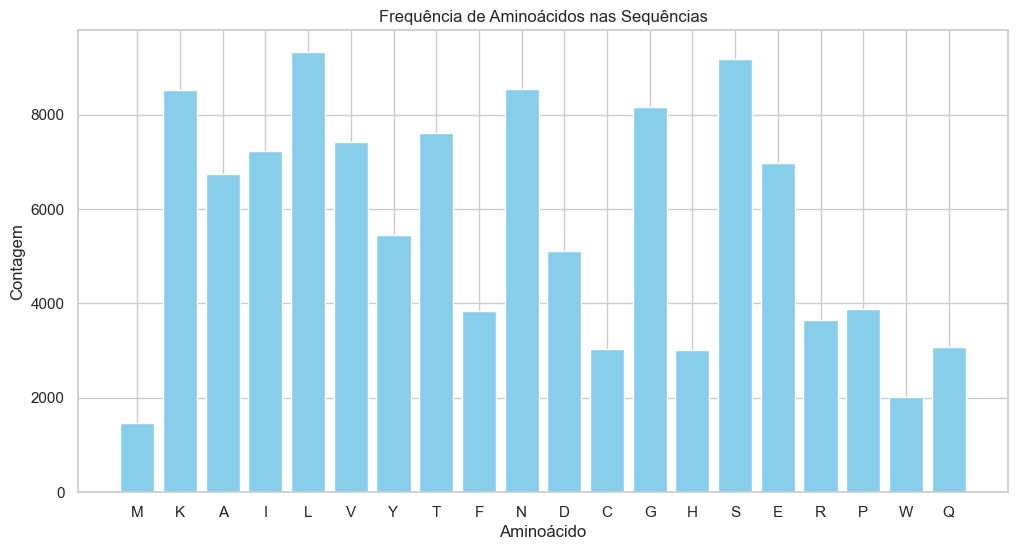

In [142]:
all_sequences = "".join(df_sequences["sequence"])

amino_acid_counts = Counter(all_sequences)

plt.figure(figsize=(12, 6))
plt.bar(amino_acid_counts.keys(), amino_acid_counts.values(), color="skyblue")
plt.title("Frequência de Aminoácidos nas Sequências")
plt.xlabel("Aminoácido")
plt.ylabel("Contagem")
plt.grid(True)
plt.show()

In [143]:
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

df_sequences["kmers"] = df_sequences["sequence"].apply(
    lambda seq: " ".join(get_kmers(seq, k=3))
)

1.4. Composição Bioquímica (Peso, Hidrofobicidade e pI)

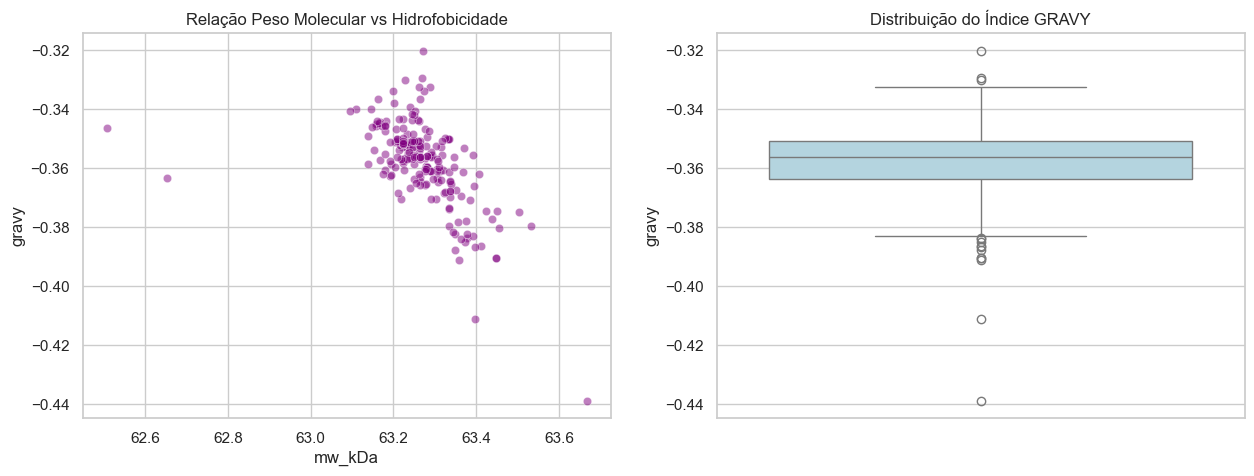

In [ ]:
aa_weights = {'A': 71.08, 'R': 156.19, 'N': 114.11, 'D': 115.09, 'C': 103.14, 'E': 129.12, 'Q': 128.13, 'G': 57.05, 'H': 137.14, 'I': 113.16, 'L': 113.16, 'K': 128.18, 'M': 131.20, 'F': 147.18, 'P': 97.12, 'S': 87.08, 'T': 101.11, 'W': 186.21, 'Y': 163.18, 'V': 99.13}
kyte_doolittle = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'E': -3.5, 'Q': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

def analyze_biochem(seq):
    mw = (sum(aa_weights.get(aa, 0) for aa in seq) + 18.02) / 1000
    gravy = sum(kyte_doolittle.get(aa, 0) for aa in seq) / len(seq)
    return mw, gravy

df_sequences[['mw_kDa', 'gravy']] = df_sequences['sequence'].apply(lambda x: pd.Series(analyze_biochem(x)))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=df_sequences, x='mw_kDa', y='gravy', alpha=0.5, ax=ax[0], color='purple')
ax[0].set_title("Relação Peso Molecular vs Hidrofobicidade")
sns.boxplot(y=df_sequences['gravy'], ax=ax[1], color='lightblue')
ax[1].set_title("Distribuição do Índice GRAVY")
plt.show()

1.5. Mutações de Virulência e Sítios de Glicosilação

In [145]:
# Padrão de Glicosilação (N-X-S/T onde X != P)
glyco_pattern = re.compile(r'N[^P][ST][^P]')
df_sequences['glyco_sites'] = df_sequences['sequence'].apply(lambda x: len(glyco_pattern.findall(x)))

# Procura de mutações específicas (Ex: D222G associada a gravidade)
known_muts = {'D222G': 222, 'S183P': 183} # Posições aproximadas
for mut, pos in known_muts.items():
    target_aa = mut[-1]
    df_sequences[mut] = df_sequences['sequence'].apply(lambda x: 1 if len(x) > pos and x[pos] == target_aa else 0)

print("Frequência de Mutações de Virulência:")
print(df_sequences[['D222G', 'S183P']].sum())

Frequência de Mutações de Virulência:
D222G    0
S183P    0
dtype: int64


C:\Users\catia\AppData\Local\Temp\ipykernel_24160\1669627949.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sequences, x='glyco_sites', palette='magma')


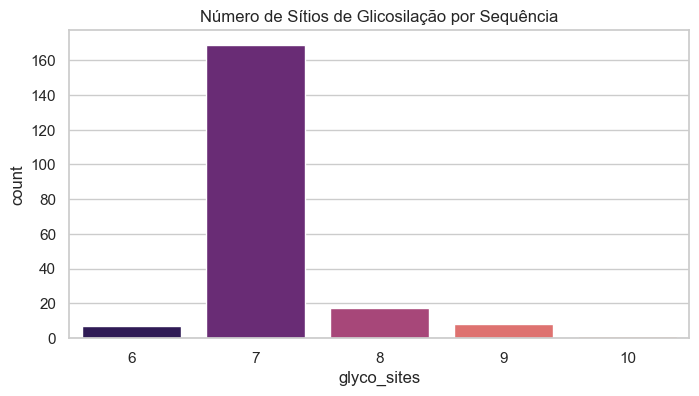

In [146]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_sequences, x='glyco_sites', palette='magma')
plt.title("Número de Sítios de Glicosilação por Sequência")
plt.show()

1.6. Mapa de Conservação (Análise por Posição)

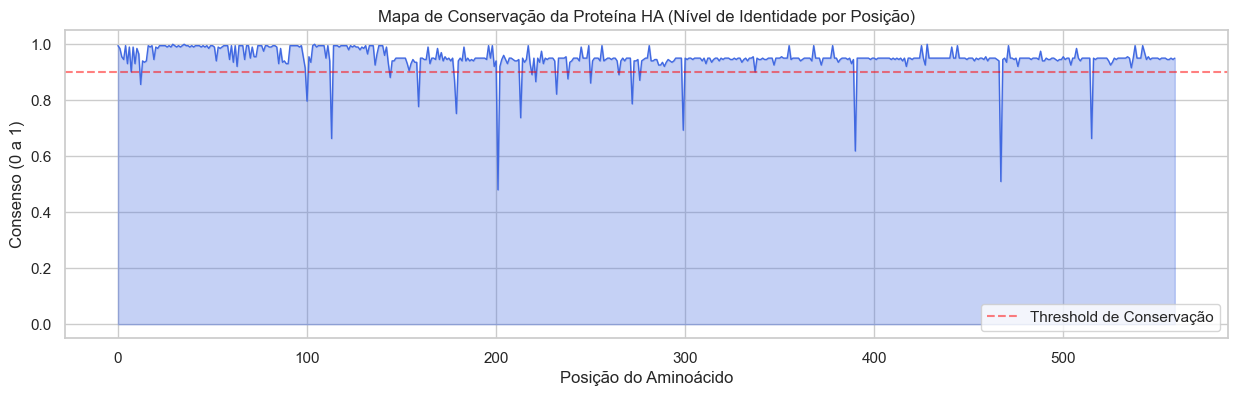

In [147]:
# Alinhamento simples (truncagem pelo menor comprimento para visualização rápida)
min_l = int(df_sequences['length'].min())
matrix = np.array([list(s[:min_l]) for s in df_sequences['sequence']])

# Identidade por posição
conservation = [Counter(matrix[:, i]).most_common(1)[0][1] / len(df_sequences) for i in range(min_l)]

plt.figure(figsize=(15, 4))
plt.plot(conservation, color='royalblue', linewidth=1)
plt.fill_between(range(min_l), conservation, alpha=0.3, color='royalblue')
plt.title("Mapa de Conservação da Proteína HA (Nível de Identidade por Posição)")
plt.xlabel("Posição do Aminoácido")
plt.ylabel("Consenso (0 a 1)")
plt.axhline(0.9, color='red', linestyle='--', alpha=0.5, label="Threshold de Conservação")
plt.legend(loc='lower right')
plt.show()

1.7. Analise de similaridade

In [148]:
def calculate_jaccard_similarity(df, top_n=50):
    """
    Calcula a similaridade de Jaccard entre as primeiras N sequências
    (limitado para garantir performance na visualização).
    """
    # Converter kmers em sets para cálculo de Jaccard
    kmer_sets = [set(k.split()) for k in df['kmers'].head(top_n)]
    n = len(kmer_sets)
    matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            intersection = len(kmer_sets[i].intersection(kmer_sets[j]))
            union = len(kmer_sets[i].union(kmer_sets[j]))
            matrix[i, j] = intersection / union if union > 0 else 0
            
    return matrix

# Calcular similaridade para as primeiras 50 sequências (amostra representativa)
sim_matrix = calculate_jaccard_similarity(df_sequences, top_n=50)

print("Matriz de similaridade calculada com sucesso.")
print(f"Dimensões da matriz: {sim_matrix.shape}")

Matriz de similaridade calculada com sucesso.
Dimensões da matriz: (50, 50)


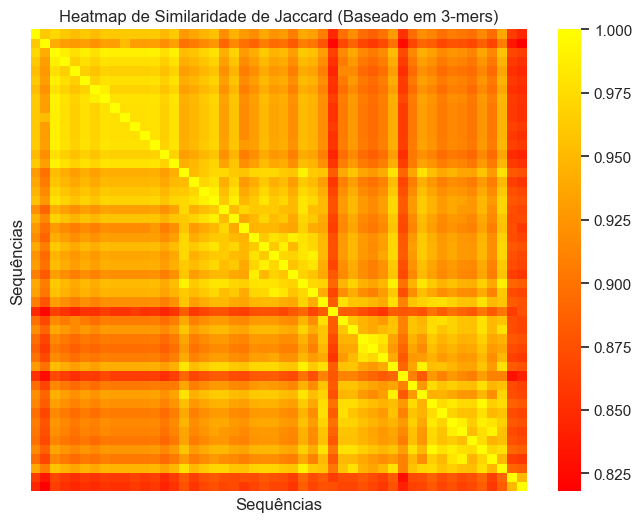

In [149]:
# Visualização do Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, cmap="autumn", xticklabels=False, yticklabels=False)
plt.title("Heatmap de Similaridade de Jaccard (Baseado em 3-mers)")
plt.xlabel("Sequências")
plt.ylabel("Sequências")
plt.show()

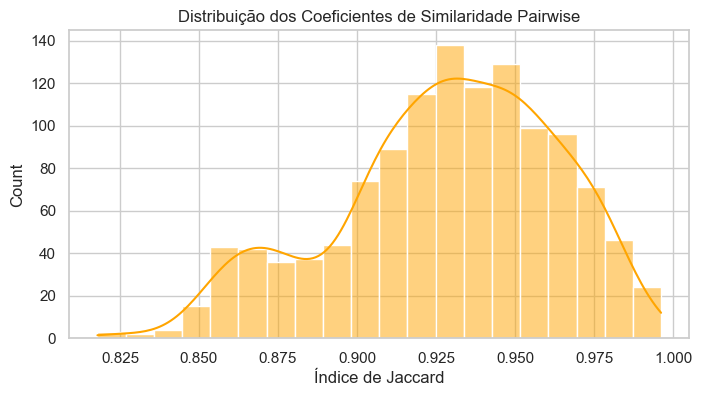

Similaridade média entre sequências: 0.9282


In [150]:
# Histograma da similaridade média
# Pegamos apenas nos valores acima da diagonal principal para evitar duplicados (k=1)
n = sim_matrix.shape[0]
avg_sim = sim_matrix[np.triu_indices(n, k=1)]

plt.figure(figsize=(8, 4))
sns.histplot(avg_sim, bins=20, color='orange', kde=True)
plt.title("Distribuição dos Coeficientes de Similaridade Pairwise")
plt.xlabel("Índice de Jaccard")
plt.show()

print(f"Similaridade média entre sequências: {avg_sim.mean():.4f}")

1.8. Fitness

In [151]:
df_sequences["fitness_label"] = df_sequences["sequence"].apply(
    lambda x: (x.count('H') + x.count('Y')) / len(x)
)

y = df_sequences["fitness_label"]

In [152]:
# Cálculo do Fitness Médio
avg_fitness = df_sequences["fitness_label"].mean()

print(f"Fitness médio calculado: {avg_fitness:.4f}")

Fitness médio calculado: 0.0740


1.9. Análise Avançada - PCA e Redução de Dimensionalidade

In [153]:
vectorizer = CountVectorizer(tokenizer=lambda s: s.split(), token_pattern=None)
X = vectorizer.fit_transform(df_sequences["kmers"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())


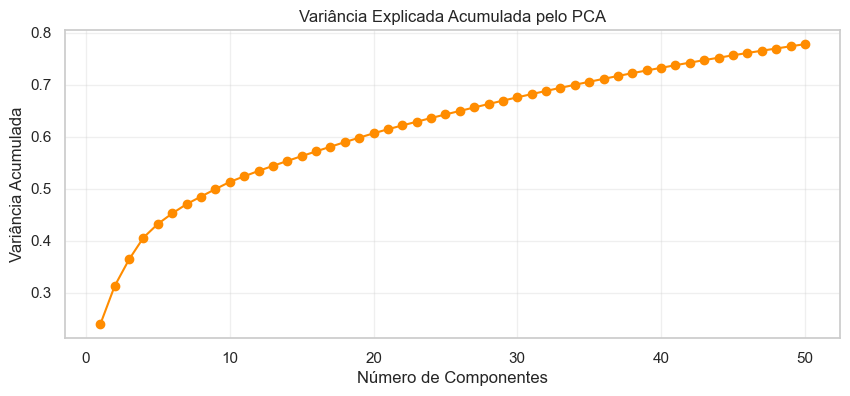

In [154]:
n_comp = min(50, X_scaled.shape[0])
pca_full = PCA(n_components=n_comp)
pca_full.fit(X_scaled)

plt.figure(figsize=(10, 4))
plt.plot(range(1, n_comp + 1), np.cumsum(pca_full.explained_variance_ratio_), marker="o", color='darkorange')
plt.title("Variância Explicada Acumulada pelo PCA")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Acumulada")
plt.grid(True, alpha=0.3)
plt.show()


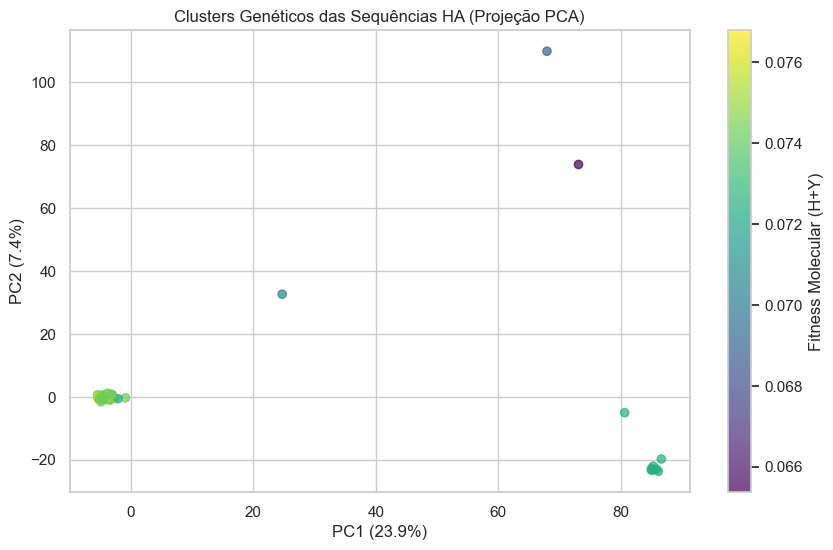

In [155]:
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_sequences['fitness_label'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Fitness Molecular (H+Y)')
plt.title("Clusters Genéticos das Sequências HA (Projeção PCA)")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
plt.show()

Exploracao Dados Epidemiologicos

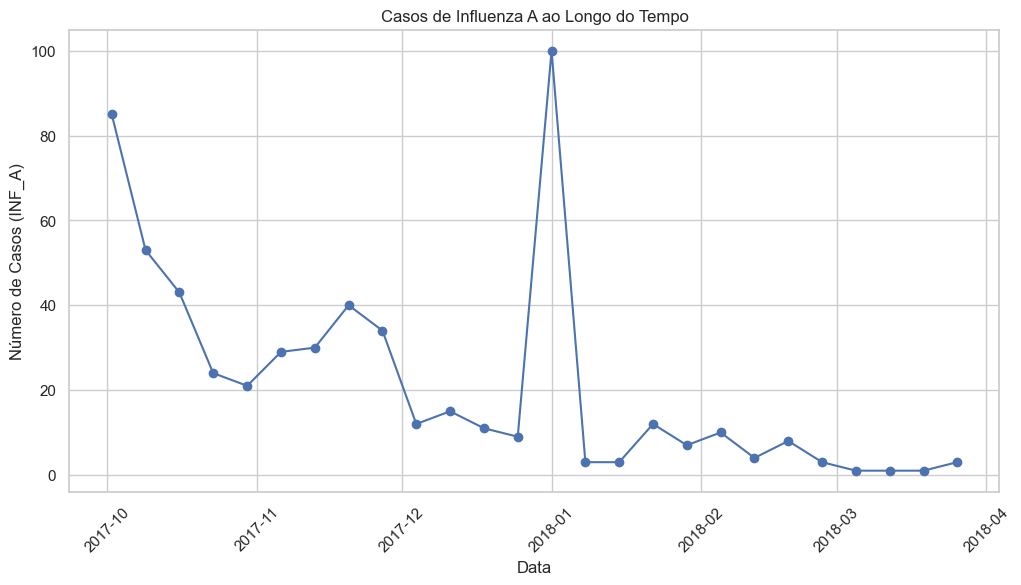

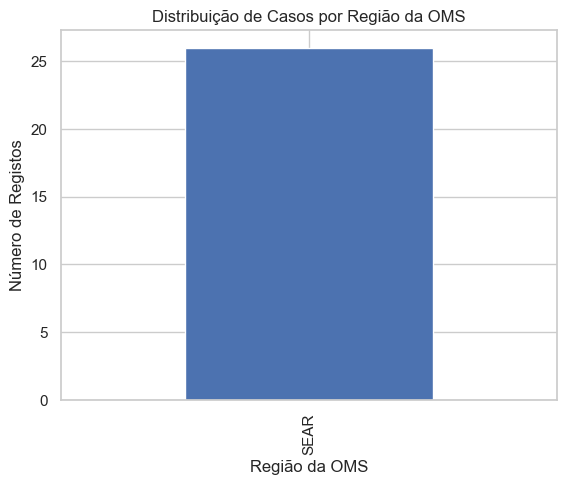

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_epi["ISO_SDATE"], df_epi["INF_A"], marker='o')
plt.title("Casos de Influenza A ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Número de Casos (INF_A)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

df_epi["WHO region"].value_counts().plot(kind="bar")
plt.title("Distribuição de Casos por Região da OMS")
plt.xlabel("Região da OMS")
plt.ylabel("Número de Registos")
plt.show()


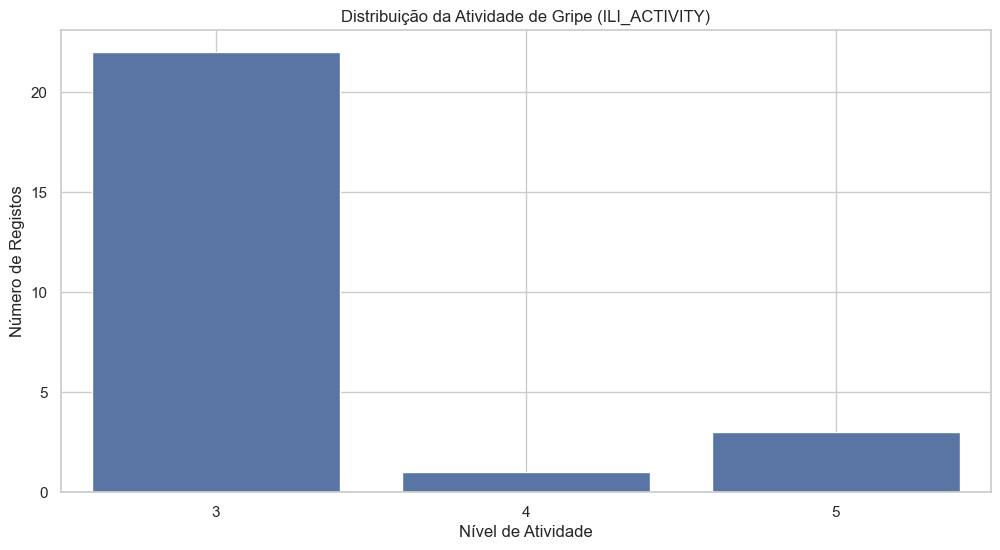

In [178]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_epi, x="ILI_ACTIVITY")
plt.title("Distribuição da Atividade de Gripe (ILI_ACTIVITY)")
plt.xlabel("Nível de Atividade")
plt.ylabel("Número de Registos")
plt.grid(True)
plt.show()


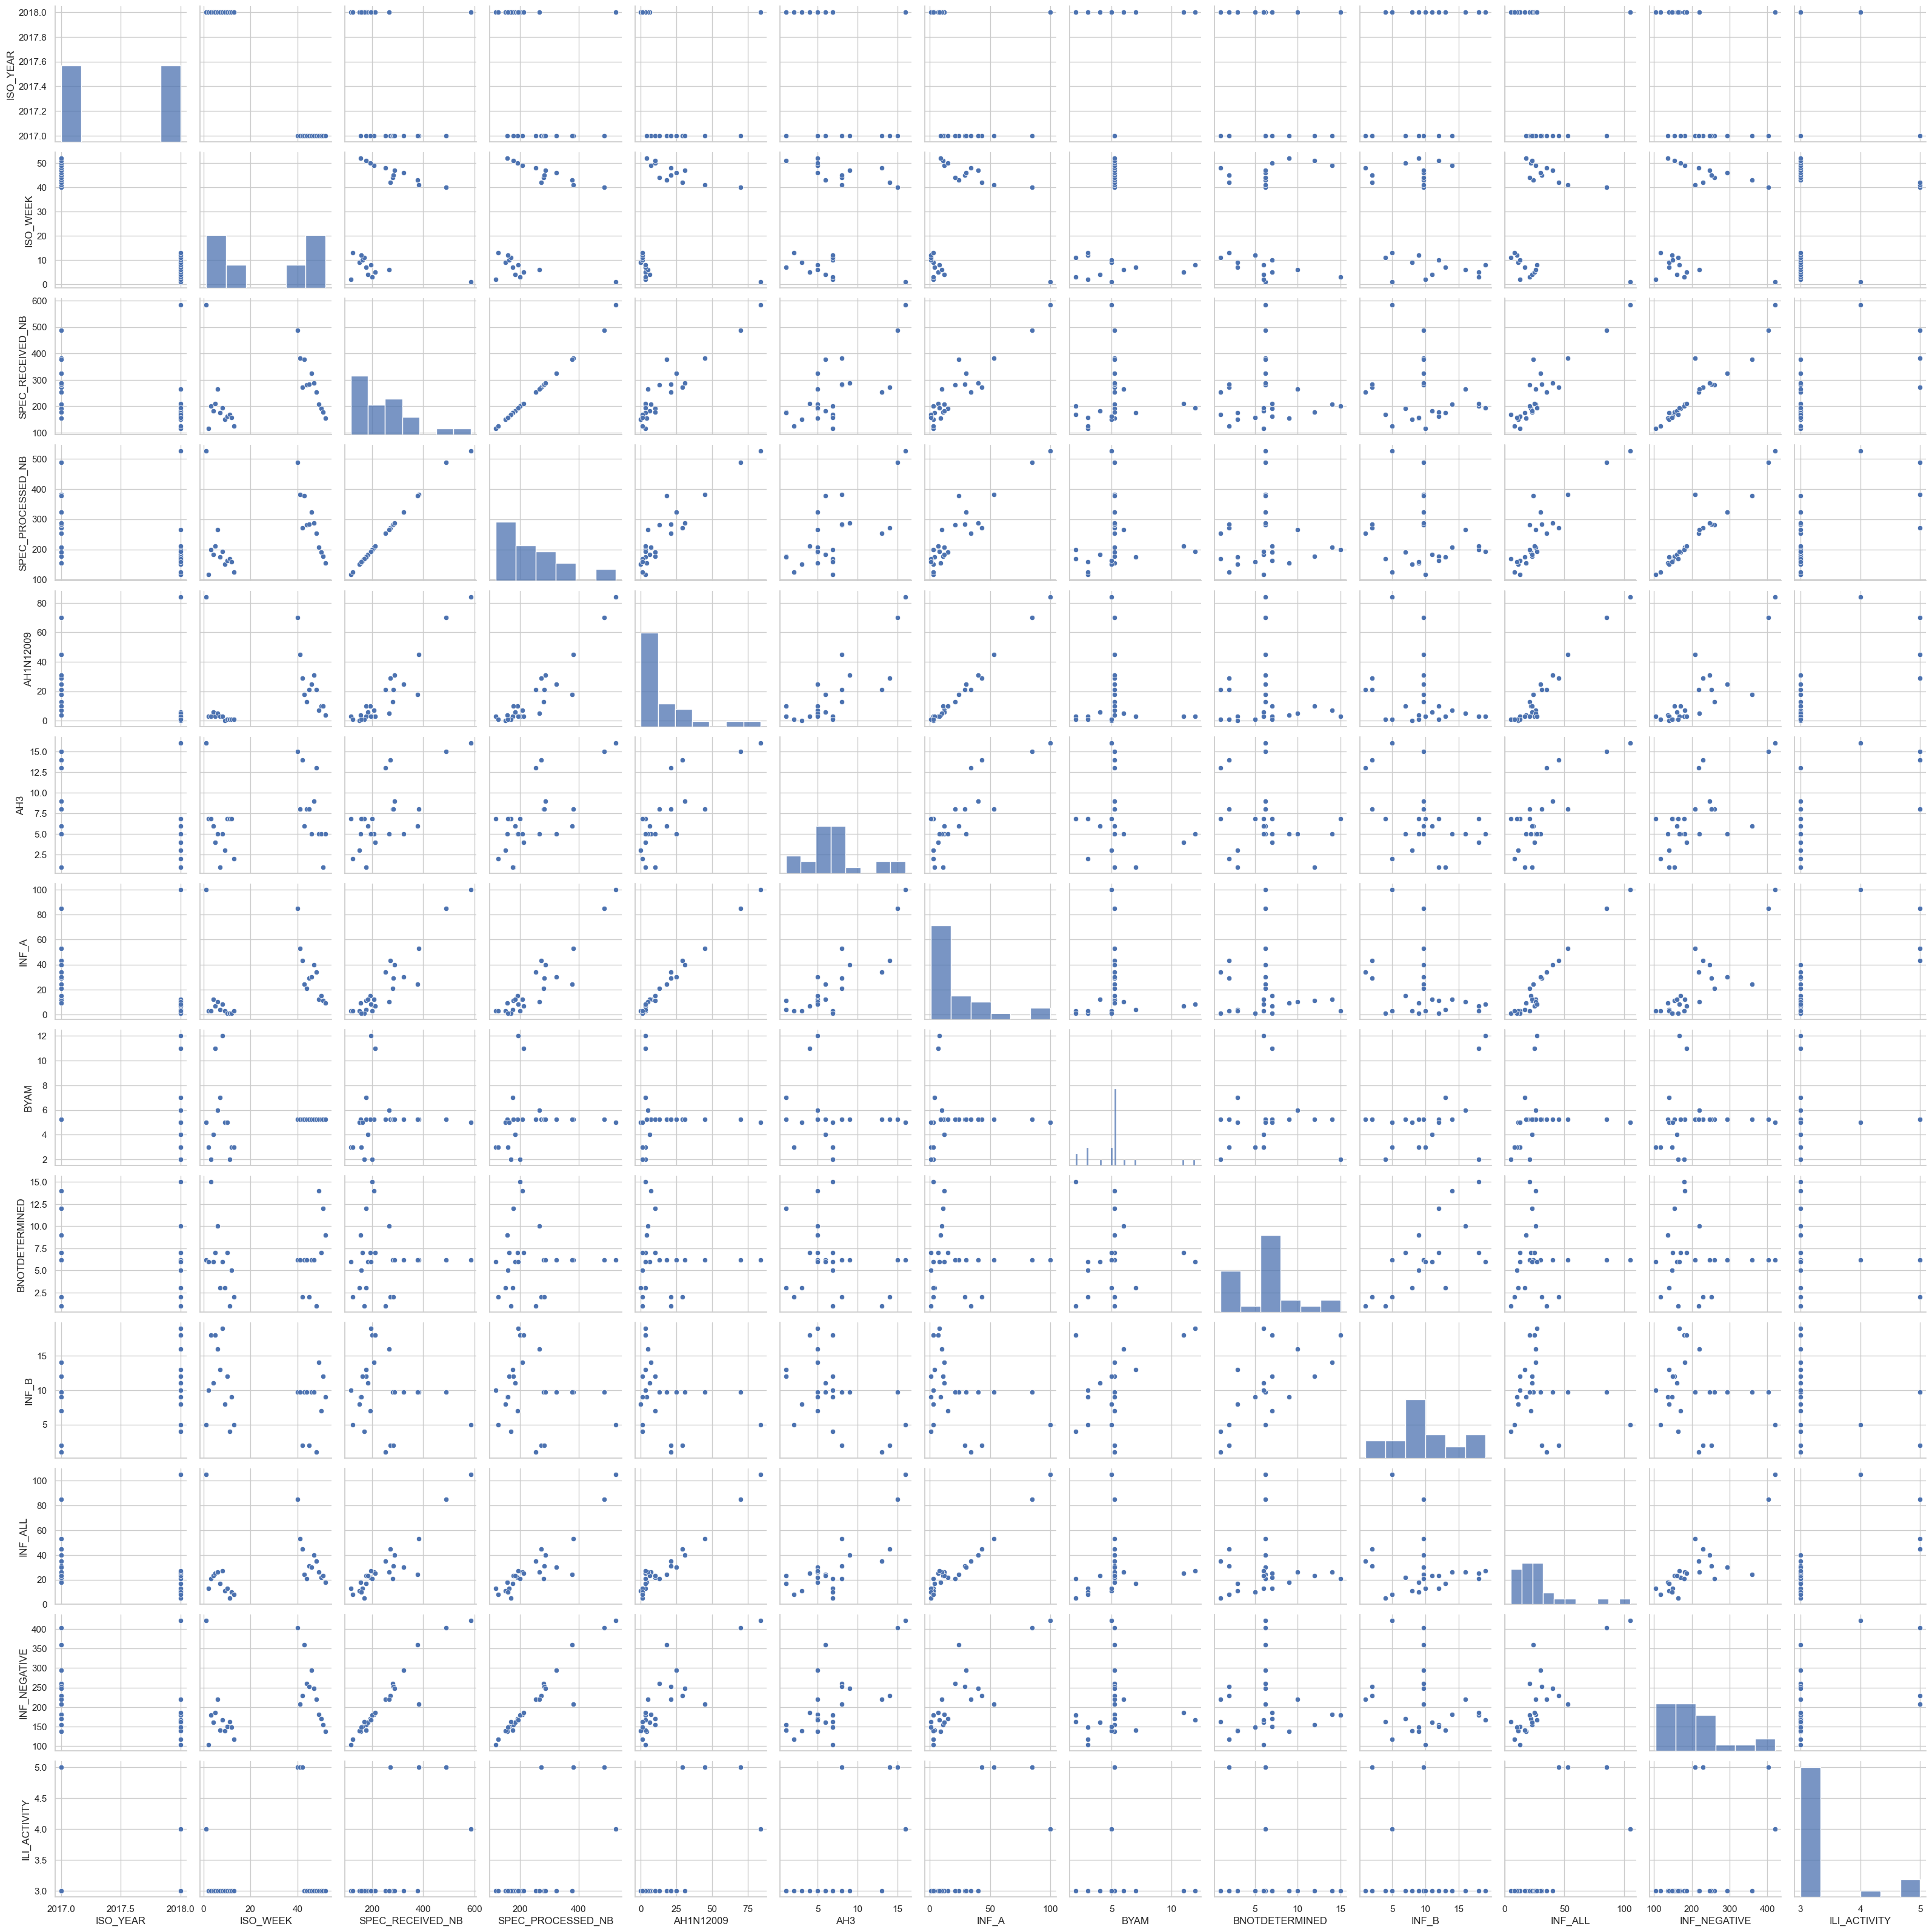

In [179]:
numeric_cols = df_epi.select_dtypes(include=[np.number]).columns
sns.pairplot(df_epi[numeric_cols])
plt.show()

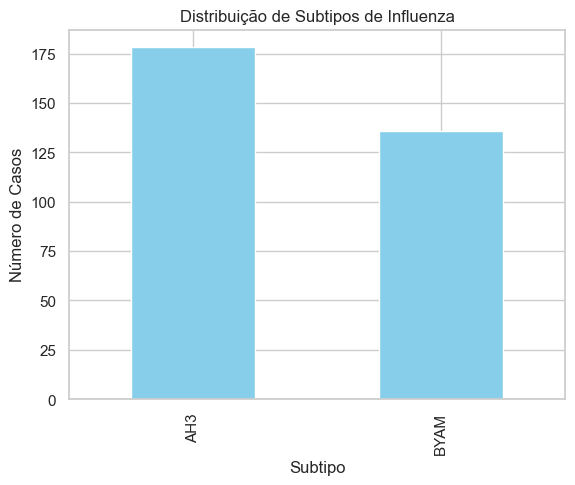

In [181]:
subtipos = ["AH3", "BYAM"]
df_epi[subtipos].sum().plot(kind="bar", color="skyblue")
plt.title("Distribuição de Subtipos de Influenza")
plt.xlabel("Subtipo")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.show()


1.10. Extração de Características e Machine Learning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_fitness = RandomForestRegressor(n_estimators=100, random_state=42)
model_fitness.fit(X_train, y_train)

new_kmers = ["ATG TGC TGA TGG"]
X_new_vec = vectorizer.transform(new_kmers)
X_new = scaler.transform(X_new_vec.toarray())
fitness = model_fitness.predict(X_new)[0]

print(f"Fitness previsto: {fitness}")

# Avaliar modelo
y_pred = model_fitness.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")

def tokenize_kmers(s):
    return s.split()

vectorizer = CountVectorizer(
    tokenizer=tokenize_kmers,
    token_pattern=None
)

# Guardar modelo e vectorizer
joblib.dump(model_fitness, "model_fitness.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


Fitness previsto: 0.07145150277190822
MSE: 3.4065013902529764e-07
R²: 0.6426698589304283


['vectorizer.pkl']

Módulo 2: Simulação Epidemiológica da População

Abordagem Baseada em Objetos
- Modelo Baseado em Agentes (ABM)
- Ideal para explorar heterogeneidade na população
- Dificil integracao com dados reais
- Flexibilidade alta
- Complexidade alta
- Desempenho baixo (para grandes populações))

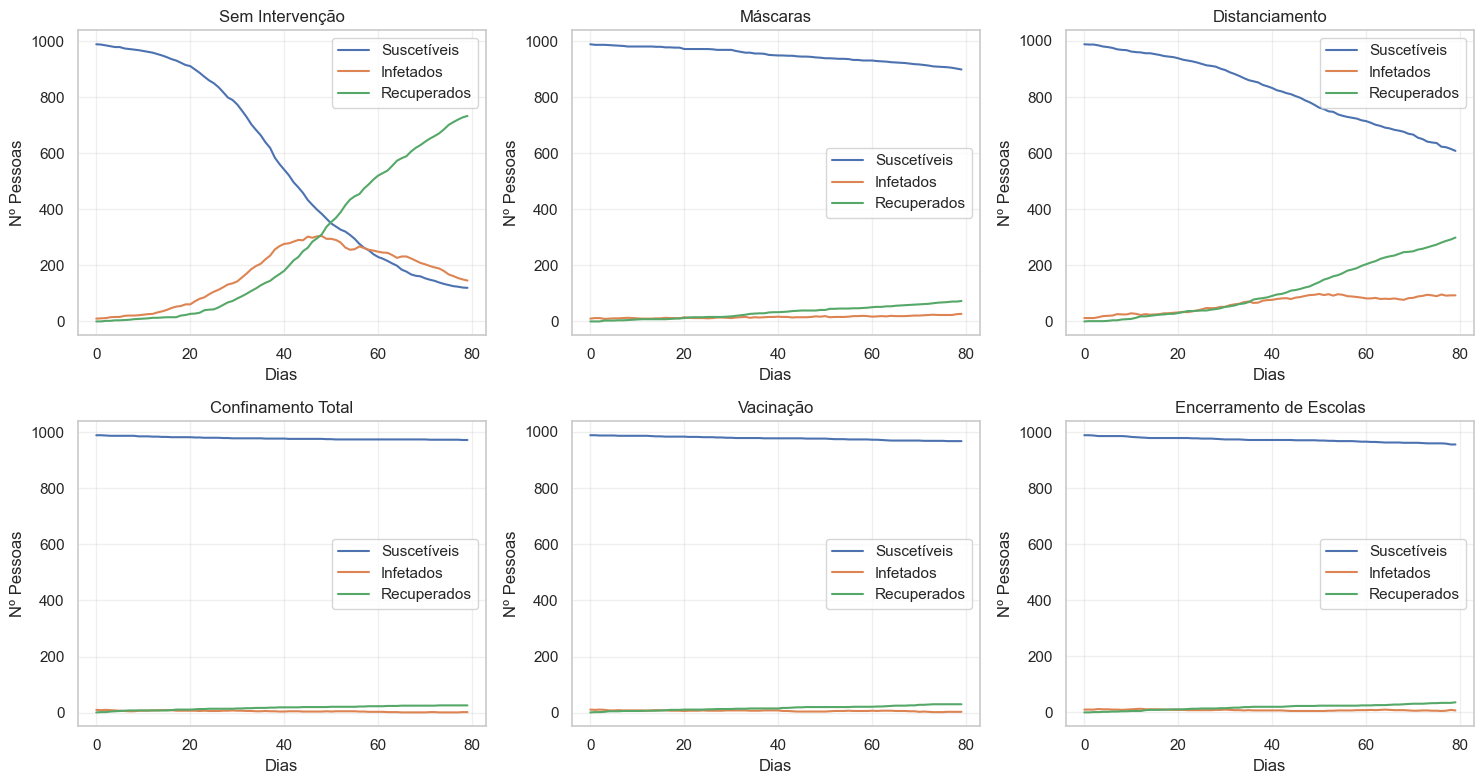

In [ ]:
class Person:
    def __init__(self, state="S", vaccinated=False):
        self.state = state
        self.vaccinated = vaccinated

class InfluenzaABM:
    def __init__(self, population_size, initial_infected, fitness_score):
        # Integração do Módulo 1
        self.fitness = fitness_score

        # Parâmetros influenciados pela aptidão viral
        self.base_beta = 0.15 * (1 + fitness_score)              # transmissibilidade
        self.recovery_rate = 0.06 / (1 + (fitness_score / 2))    # demora mais a recuperar se fitness maior
        self.severe_rate = 0.01 * (1 + fitness_score)            # gravidade potencial

        # Criar população
        self.population = [Person("S") for _ in range(population_size)]

        # Infectar os primeiros indivíduos
        initial_idx = random.sample(range(population_size), initial_infected)
        for idx in initial_idx:
            self.population[idx].state = "I"

        self.history = []

    def apply_intervention(self, intervention):
        beta = self.base_beta

        if intervention is None:
            return beta

        # Máscaras
        if intervention == "mask":
            beta *= 0.5

        # Distanciamento
        elif intervention == "distancing":
            beta *= 0.6

        # Confinamento total (nova intervenção)
        elif intervention == "lockdown":
            beta *= 0.2

        # Vacinação em massa
        elif intervention == "vaccination":
            for p in self.population:
                if p.state == "S":
                    p.vaccinated = True
            beta *= 0.7
        
        elif intervention == "schools":
            beta *= 0.45

        return beta

    def step(self, intervention=None):
        beta = self.apply_intervention(intervention)

        new_states = []

        infected_people = [p for p in self.population if p.state == "I"]

        for person in self.population:
            if person.state == "S":
                protection = 0.6 if person.vaccinated else 0.0
                risk = beta * max(len(infected_people), 1) / len(self.population)
                risk *= (1 - protection)

                if random.random() < risk:
                    new_states.append("I")
                else:
                    new_states.append("S")

            elif person.state == "I":
                if random.random() < self.recovery_rate:
                    new_states.append("R")
                else:
                    new_states.append("I")

            else:
                new_states.append("R")

        for i, p in enumerate(self.population):
            p.state = new_states[i]

        self.history.append(self.count_states())

    def count_states(self):
        S = sum(p.state == "S" for p in self.population)
        I = sum(p.state == "I" for p in self.population)
        R = sum(p.state == "R" for p in self.population)
        return {"S": S, "I": I, "R": R}

def run_scenarios(fitness):
    scenarios = {
        "Sem Intervenção": None,
        "Máscaras": "mask",
        "Distanciamento": "distancing",
        "Confinamento Total": "lockdown",
        "Vacinação": "vaccination",
        "Encerramento de Escolas": "schools"
    }

    results = {}

    for name, policy in scenarios.items():
        model = InfluenzaABM(
            population_size=1000,
            initial_infected=10,
            fitness_score=fitness
        )

        hist = model.run(steps=80, intervention=policy)
        results[name] = pd.DataFrame(hist)

    return results

# Adicionar método run ao InfluenzaABM
def run(self, steps=100, intervention=None):
    for _ in range(steps):
        self.step(intervention)
    return self.history

InfluenzaABM.run = run

def plot_scenarios_2x2(results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for ax, (name, df) in zip(axes, results.items()):
        ax.plot(df["S"], label="Suscetíveis")
        ax.plot(df["I"], label="Infetados")
        ax.plot(df["R"], label="Recuperados")
        ax.set_title(name)
        ax.set_xlabel("Dias")
        ax.set_ylabel("Nº Pessoas")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Exemplo de uso
fitness = avg_fitness
results = run_scenarios(fitness)
plot_scenarios_2x2(results)

Abordagem Baseada em Populacao
- Modelo SIR Simplificado
- Ideal para comparar com dados epidemiológicos reais e explorar cenários de intervenção
- Facil integracao com dados reais
- Flexibilidade baixa
- Complexidade baixa
- Desempenho alto

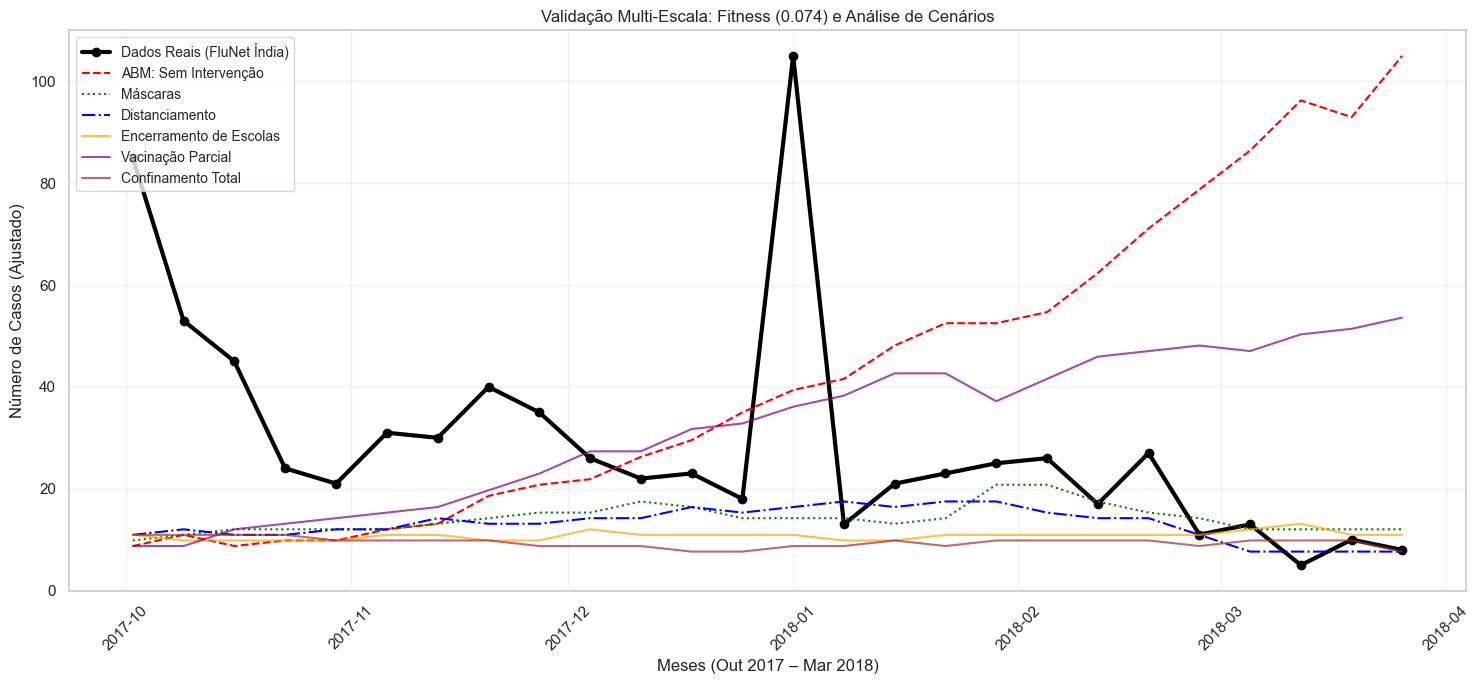

In [ ]:
# MODELO ABM MULTI-ESCALA
class InfluenzaABM:
    def __init__(self, population_size, initial_infected, fitness_score):
        self.pop_size = population_size
        self.susceptible = population_size - initial_infected
        self.infected = initial_infected
        self.recovered = 0
        
        # fitness molecular -> aumenta transmissibilidade
        self.base_beta = 0.15 * (1 + fitness_score)
        self.recovery_rate = 0.08
        
    def step(self, intervention=None):
        beta = self.base_beta
        
        # CENÁRIOS
        if intervention == "mask":
            beta *= 0.6                          # 40% redução
        
        elif intervention == "distancing":
            beta *= 0.5                          # 50% redução
        
        elif intervention == "schools":
            beta *= 0.45                         # escolas fechadas
        
        elif intervention == "vaccination":
            # vacinação reduz suscetíveis progressivamente
            vaccinated_today = int(self.susceptible * 0.01)
            self.susceptible = max(0, self.susceptible - vaccinated_today)
            
        elif intervention == "lockdown":
            beta *= 0.2

        
        new_inf = np.random.binomial(
            self.susceptible,
            min(beta * (self.infected / self.pop_size), 1.0)
        )
        
        new_rec = np.random.binomial(self.infected, self.recovery_rate)
        
        self.susceptible -= new_inf
        self.infected += (new_inf - new_rec)
        self.recovered += new_rec
        
        return self.infected


# EXECUTAR TODAS AS SIMULAÇÕES
n_steps = len(df_epi)

scenarios = {
    "baseline": None,
    "mask": "mask",
    "distancing": "distancing",
    "schools": "schools",
    "vaccination": "vaccination",
    "lockdown": "lockdown"
}

results = {}

for name, scenario in scenarios.items():
    model = InfluenzaABM(5000, 10, avg_fitness)
    history = [model.step(intervention=scenario) for _ in range(n_steps)]
    results[name] = history

scale_factor = df_epi["INF_ALL"].max() / max(results["baseline"])

# PLOT FINAL
plt.figure(figsize=(15, 7))

# dados reais
plt.plot(
    df_epi["ISO_SDATE"],
    df_epi["INF_ALL"],
    label="Dados Reais (FluNet Índia)",
    color="black",
    linewidth=3,
    marker="o"
)

# baseline
plt.plot(
    df_epi["ISO_SDATE"],
    np.array(results["baseline"]) * scale_factor,
    "--",
    color="red",
    label="ABM: Sem Intervenção"
)

# restantes cenários
plt.plot(df_epi["ISO_SDATE"], np.array(results["mask"]) * scale_factor, ":", color="green", label="Máscaras")
plt.plot(df_epi["ISO_SDATE"], np.array(results["distancing"]) * scale_factor, "-.", color="blue", label="Distanciamento")
plt.plot(df_epi["ISO_SDATE"], np.array(results["schools"]) * scale_factor, "-", color="orange", alpha=0.7, label="Encerramento de Escolas")
plt.plot(df_epi["ISO_SDATE"], np.array(results["vaccination"]) * scale_factor, "-", color="purple", alpha=0.7, label="Vacinação Parcial")
plt.plot(df_epi["ISO_SDATE"], np.array(results["lockdown"]) * scale_factor, "-", color="brown", alpha=0.7, label="Confinamento Total")

plt.title(f"Validação Multi-Escala: Fitness ({avg_fitness:.3f}) e Análise de Cenários")
plt.xlabel("Meses (Out 2017 – Mar 2018)")
plt.ylabel("Número de Casos (Ajustado)")
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.25)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

